## Introduction

... bla bla bla

In [1]:
# Basic data manipulation
import pandas as pd
import numpy as np
import random
import json

# Visualization
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV

# Classifiers
from catboost import CatBoostClassifier

# Additional encoders
import category_encoders as ce

# Stats
import scipy.stats as stats

# Dimensionality reduction
from sklearn.decomposition import (
    PCA,
    KernelPCA, 
    FastICA,
    TruncatedSVD
)

# PSO
from pyswarm import pso



# Data Analysis

### Dataset Overview

The IEEE-CIS Fraud Detection dataset, sourced from Kaggle, comprises 590,540 transactions, with approximately 3.5% flagged as fraudulent. It includes two main components: transaction data (e.g., amount, time, product code) and identity data (e.g., device type, email domain), linked via 'TransactionID'. The high dimensionality (over 400 features) and class imbalance make it an ideal testbed for comparing feature selection and dimensionality reduction strategies.

### 1. First and foremost, merge two dbs into one

In [4]:
train_transaction = pd.read_csv("data/train_transaction.csv")
train_identity = pd.read_csv("data/train_identity.csv")

# Merge both dataframes on 'TransactionID'
train = pd.merge(train_transaction, train_identity, on="TransactionID", how="left")

print(f"Rows in merged training set: {train.shape[0]}")
print(f"Columns in merged training set: {train.shape[1]}")
train.head()

KeyboardInterrupt: 

### 2. Download testing data

In [3]:
test_identity = pd.read_csv("data/test_identity.csv")
test_transaction = pd.read_csv("data/test_transaction.csv")
test = pd.merge(test_transaction, test_identity, on="TransactionID", how="left")

In [4]:
test.columns = test.columns.str.replace('-', '_')

### 3. Perform an initial exploratory data analysis (EDA) by checking missing value percentages and examining the target distribution.

In [5]:
# To make pandas show full output
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
# Missing value percentages per column
missing_percent = (train.isnull().sum() / len(train)) * 100
missing_percent = missing_percent.sort_values(ascending=False)
print("Missing percentages per column:")
print(missing_percent[missing_percent > 0])

Missing percentages per column:
id_24            99.196159
id_25            99.130965
id_07            99.127070
id_08            99.127070
id_21            99.126393
id_26            99.125715
id_27            99.124699
id_23            99.124699
id_22            99.124699
dist2            93.628374
D7               93.409930
id_18            92.360721
D13              89.509263
D14              89.469469
D12              89.041047
id_03            88.768923
id_04            88.768923
D6               87.606767
id_33            87.589494
id_10            87.312290
id_09            87.312290
D9               87.312290
D8               87.312290
id_30            86.865411
id_32            86.861855
id_34            86.824771
id_14            86.445626
V142             86.123717
V158             86.123717
V140             86.123717
V162             86.123717
V141             86.123717
V161             86.123717
V157             86.123717
V146             86.123717
V156             86.123

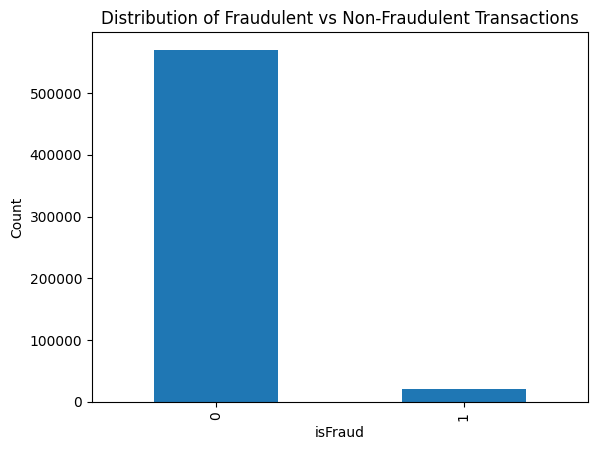

In [14]:
# Distribution of the target variable 'isFraud'
train['isFraud'].value_counts().plot(kind='bar')
plt.title("Distribution of Fraudulent vs Non-Fraudulent Transactions")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()

In [15]:
# Columns where number of nulls exceeds 90%
null_cols = [col for col in train.columns if train[col].isna().sum() > 0.9 * len(train)]
null_cols

['dist2',
 'D7',
 'id_07',
 'id_08',
 'id_18',
 'id_21',
 'id_22',
 'id_23',
 'id_24',
 'id_25',
 'id_26',
 'id_27']

In [16]:
# Find correlations between columns with nulls and target
missing_df = train.copy(deep=True)
for col in null_cols:
    missing_df["m_flag_"+col] = np.where(missing_df[col].isnull(), 1, 0)
    correlation = missing_df[["m_flag_"+col, 'isFraud']].corr()
    print(correlation)


              m_flag_dist2   isFraud
m_flag_dist2      1.000000 -0.091096
isFraud          -0.091096  1.000000
           m_flag_D7   isFraud
m_flag_D7   1.000000 -0.164478
isFraud    -0.164478  1.000000
              m_flag_id_07   isFraud
m_flag_id_07      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_08   isFraud
m_flag_id_08      1.000000 -0.024333
isFraud          -0.024333  1.000000
              m_flag_id_18   isFraud
m_flag_id_18      1.000000 -0.074815
isFraud          -0.074815  1.000000
              m_flag_id_21  isFraud
m_flag_id_21       1.00000 -0.02431
isFraud           -0.02431  1.00000
              m_flag_id_22   isFraud
m_flag_id_22      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_23   isFraud
m_flag_id_23      1.000000 -0.024252
isFraud          -0.024252  1.000000
              m_flag_id_24   isFraud
m_flag_id_24      1.000000 -0.024345
isFraud          -0.024345  1.000000
              m_flag_i

Only correlation with D7 exceeds 0.1, others are not really sufficient

### 4. Identify categorical values

In [6]:
categorical_features = train.select_dtypes(include=['object', 'category']).columns
for col in categorical_features:
    print(col, len(set(train[col])), set(train[col]))

ProductCD 5 {'C', 'W', 'R', 'S', 'H'}
card4 5 {'discover', nan, 'american express', 'visa', 'mastercard'}
card6 5 {nan, 'debit', 'charge card', 'credit', 'debit or credit'}
P_emaildomain 60 {'ptd.net', 'live.fr', 'protonmail.com', 'sbcglobal.net', 'gmail.com', 'earthlink.net', 'live.com.mx', 'comcast.net', 'yahoo.es', 'hotmail.co.uk', 'verizon.net', 'charter.net', 'att.net', 'ymail.com', 'yahoo.com.mx', 'hotmail.com', nan, 'live.com', 'frontier.com', 'hotmail.es', 'windstream.net', 'aol.com', 'rocketmail.com', 'juno.com', 'twc.com', 'roadrunner.com', 'msn.com', 'embarqmail.com', 'outlook.es', 'yahoo.com', 'gmail', 'suddenlink.net', 'aim.com', 'yahoo.co.jp', 'centurylink.net', 'netzero.net', 'cox.net', 'mail.com', 'me.com', 'anonymous.com', 'gmx.de', 'frontiernet.net', 'hotmail.fr', 'outlook.com', 'web.de', 'mac.com', 'prodigy.net.mx', 'q.com', 'yahoo.co.uk', 'cableone.net', 'optonline.net', 'hotmail.de', 'yahoo.fr', 'icloud.com', 'netzero.com', 'cfl.rr.com', 'servicios-ta.com', 'sc.rr.

We can see that some features (id_30, id_31, id_33, DeviceInfo) have a lot of different values that makes encoding harder

#### Find truly categorical values

Screen resolution values are true numerical values, while all other features are categorical in nature

In [7]:
# Split column id_33 to Width and Height
train[['Screen_Width', 'Screen_Height']] = train['id_33'].str.split('x', expand=True).astype(float)
train = train.drop(columns=['id_33'])

In [8]:
test[['Screen_Width', 'Screen_Height']] = test['id_33'].str.split('x', expand=True).astype(float)
test = test.drop(columns=['id_33'])

#### Some columns have integer type, but they categorical in nature, since they have too few distinct values, we need to identify it as categorical features

In [9]:
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Identify candidate categorical features based on unique value counts
candidate_categorical = {}
# Set a threshold for maximum unique values
unique_threshold = 20

# Iterate over numeric columns to check unique value counts
for col in train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = train[col].nunique()
    if (unique_vals < unique_threshold) and (col != "isFraud"):
        candidate_categorical[col] = unique_vals

# Print candidate categorical features
print("Candidate categorical features (numeric columns with few unique values):")
for col, count in candidate_categorical.items():
    print(f"{col}: {count} unique values")

Candidate categorical features (numeric columns with few unique values):
V1: 2 unique values
V2: 9 unique values
V3: 10 unique values
V4: 7 unique values
V5: 7 unique values
V6: 10 unique values
V7: 10 unique values
V8: 9 unique values
V9: 9 unique values
V10: 5 unique values
V11: 6 unique values
V12: 4 unique values
V13: 7 unique values
V14: 2 unique values
V15: 8 unique values
V16: 15 unique values
V17: 16 unique values
V18: 16 unique values
V19: 8 unique values
V20: 15 unique values
V21: 6 unique values
V22: 9 unique values
V23: 14 unique values
V24: 14 unique values
V25: 7 unique values
V26: 13 unique values
V27: 4 unique values
V28: 4 unique values
V29: 6 unique values
V30: 8 unique values
V31: 8 unique values
V32: 15 unique values
V33: 7 unique values
V34: 13 unique values
V35: 4 unique values
V36: 6 unique values
V39: 16 unique values
V40: 18 unique values
V41: 2 unique values
V42: 9 unique values
V43: 9 unique values
V46: 7 unique values
V47: 9 unique values
V48: 6 unique value

# Data Preprocessing

### 1. Imputing nulls

We want to leave as much features as possible, so Genetic Algorithm will select the most valuable ones. Therefore, we need smart imputation

Not using standard imputation:
1. Placed zero values as indicator for missing values where feature values no zero values anywhere else
2. Added 'missing' instead of null for categorical values to keep all the columns

In [10]:
# Identify numeric and categorical columns
num_cols = train.select_dtypes(include=['int64', 'float64']).columns
cat_cols = list(set(cat_cols).union(set(candidate_categorical.keys()))) # Union of categorical values with numeric ones that actually caegorical
num_cols = [col for col in num_cols if col not in cat_cols and col not in ("TransactionID", "isFraud")]

# Imputation for numeric columns using zeros as indicator
num_imputer = SimpleImputer(strategy='constant', fill_value=0)
train[num_cols] = num_imputer.fit_transform(train[num_cols])

# Imputation for categorical columns using a constant value
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
train[cat_cols] = cat_imputer.fit_transform(train[cat_cols])

# Confirm that no missing values remain (or check overall missing count)
print("Total missing values after imputation:", train.isnull().sum().sum())

Total missing values after imputation: 0


In [11]:
test[num_cols] = num_imputer.transform(test[num_cols])
test[cat_cols] = cat_imputer.transform(test[cat_cols])
print("Total missing values after imputation:", train.isnull().sum().sum())

Total missing values after imputation: 0


### 2. Data encoding

In [12]:
X = train.drop(columns=["isFraud", "TransactionID"])
y = train['isFraud']

Splitting train and validation asap

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Encoding categorical features

Using novel thing: WOE encoder to compensate for an enormous dimentionality for SVC

In [14]:
encoder_high = ce.WOEEncoder(cols=cat_cols)
X_train_encoded_cat = encoder_high.fit_transform(X_train[cat_cols], y_train)
X_val_encoded_cat = encoder_high.transform(X_val[cat_cols])

In [15]:
test_encoded_cat = encoder_high.transform(test[cat_cols])

### 3. Data normalization

Scale data to remove any disrepancies in SVC

In [16]:
X_train_for_scaling = pd.DataFrame(np.hstack([X_train_encoded_cat, X_train[num_cols]]), columns=cat_cols + num_cols)
X_val_for_scaling = pd.DataFrame(np.hstack([X_val_encoded_cat, X_val[num_cols]]), columns=cat_cols + num_cols)
test_for_scaling = pd.DataFrame(np.hstack([test_encoded_cat, test[num_cols]]), columns=cat_cols + num_cols)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_for_scaling)
X_val_scaled = scaler.transform(X_val_for_scaling)

In [18]:
test_scaled = scaler.transform(test_for_scaling)

In [19]:
print("Encoded training set shape:", X_train_scaled.shape)
print("Encoded validation set shape:", X_val_scaled.shape)

Encoded training set shape: (472432, 433)
Encoded validation set shape: (118108, 433)


In [20]:
print("Encoded test set shape:", test_scaled.shape)

Encoded test set shape: (506691, 433)


In [21]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=cat_cols + num_cols)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=cat_cols + num_cols)
test_scaled = pd.DataFrame(test_scaled, columns=cat_cols + num_cols)

In [22]:
X_train_scaled.head()

,V35,V31,M4,R_emaildomain,V122,V75,V84,id_38,V69,V57,V93,V63,V240,V297,V65,V50,V42,V83,V112,V32,V3,id_24,V41,V305,V4,V25,V110,M7,V301,M2,V197,V18,V304,M5,V53,V76,id_18,V325,id_27,id_16,id_34,V175,V64,V141,V8,V15,V173,id_32,V79,V194,V142,DeviceInfo,V94,V250,V19,M3,V288,V113,V328,V48,id_15,V51,V153,card4,V286,V98,id_35,V119,V27,V9,V92,V251,V61,id_28,V195,id_36,V34,V7,V23,V108,V121,V88,V29,V12,V115,V47,V26,M9,V66,V43,V59,V114,id_37,V89,V223,V74,V49,P_emaildomain,V68,V111,id_04,V36,V124,V58,V107,V33,V46,V21,V82,V109,V125,id_31,id_12,V73,V52,V116,V13,V302,V104,M1,V17,V6,V24,id_29,V10,V54,V30,V154,V22,V72,V71,V247,V300,V67,V289,V62,V85,V11,V70,id_30,V40,V5,V20,V91,V117,ProductCD,M6,DeviceType,V14,V16,V1,V2,V28,V123,V327,V60,V174,V118,V241,V284,V90,V260,V120,id_23,card6,V55,M8,V39,V184,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V37,V38,V44,V45,V56,V77,V78,V80,V81,V86,V87,V95,V96,V97,V99,V100,V101,V102,V103,V105,V106,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V176,V177,V178,V179,V180,V181,V182,V183,V185,V186,V187,V188,V189,V190,V191,V192,V193,V196,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V248,V249,V252,V253,V254,V255,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V290,V291,V292,V293,V294,V295,V296,V298,V299,V303,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V326,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_21,id_22,id_25,id_26,Screen_Width,Screen_Height
0,0.249562,0.985555,-0.803152,0.118149,-0.041814,0.992088,0.893506,1.247671,0.894435,1.232184,0.890458,1.245603,1.872586,-0.108377,2.571279,0.385468,0.385747,1.208605,-0.069307,0.985460,1.007737,-0.083475,0.911749,-0.004593,1.032669,2.302824,-0.083589,0.837200,-0.193018,1.036899,1.273024,0.998680,1.686335,0.519333,1.404020,0.958821,-0.272797,2.335583,-0.093859,2.514579,0.952800,1.702710,1.241917,1.536652,1.047713,0.994488,1.817448,-0.219531,0.898955,1.279735,1.521277,-1.730724,0.880040,1.467761,1.789589,1.024527,-0.397750,-0.055439,1.274964,0.340548,2.300246,0.412278,0.496301,-1.478242,-0.154066,-0.234589,0.770854,-0.031981,2.414832,1.020952,0.885887,1.414944,1.815534,2.262642,1.249385,1.834438,0.973051,1.036516,1.445070,-0.066125,-0.065564,2.369663,0.738068,1.126510,-0.162702,0.312541,2.126737,0.806283,1.966465,0.390126,1.241881,-0.090673,1.872156,2.178445,1.856694,1.198272,0.341725,-0.752456,2.534823,-0.04969,2.779126,0.256668,-0.22275,1.236209,-0.003584,0.981250,0.294440,0.995269,1.337633,-0.114522,-0.182099,-0.618445,1.832608,1.209208,0.418686,-0.116566,1.080244,1.731517,-0.130335,1.084328,0.998054,1.048459,1.485220,2.293979,0.803947,1.342816,0.739264,0.29589,0.995308,1.241366,1.237255,1.636341,-0.183244,1.725030,-0.356303,1.662194,0.894948,0.804832,0.892424,-0.191768,0.402837,1.011969,1.667083,0.674694,-0.028718,0.514525,1.526335,1.432970,2.591129,0.994217,1.054511,1.042615,2.432304,-0.14449,1.503569,1.239407,1.742640,-0.042189,1.873777,-0.284724,0.675531,1.652838,-0.033802,-0.089246,1.72043,1.822244,0.816915,0.397178,1.574612,-1.378728,-0.145302,-0.759998,0.257853,-0.203484,-1.078432,0.042876,0.360192,-0.196545,-0.094803,-0.098434,-0.092693,-0.039137,-0.030306,-0.215803,-0.113225,-0.046189,-0.032914,-0.268532,-0.033820,-0.098328,-0.047102,-0.236331,-0.147581,3.269944,3.383160,-0.323817,-0.576067,-0.309651,-0.155767,-0.099152,6.159508,2.726051,-0.61602

In [23]:
test_scaled = pd.DataFrame(np.hstack([test[["TransactionID"]], test_scaled]), columns=["TransactionID"] + list(test_scaled.columns))
test_scaled.head()

,TransactionID,V35,V31,M4,R_emaildomain,V122,V75,V84,id_38,V69,V57,V93,V63,V240,V297,V65,V50,V42,V83,V112,V32,V3,id_24,V41,V305,V4,V25,V110,M7,V301,M2,V197,V18,V304,M5,V53,V76,id_18,V325,id_27,id_16,id_34,V175,V64,V141,V8,V15,V173,id_32,V79,V194,V142,DeviceInfo,V94,V250,V19,M3,V288,V113,V328,V48,id_15,V51,V153,card4,V286,V98,id_35,V119,V27,V9,V92,V251,V61,id_28,V195,id_36,V34,V7,V23,V108,V121,V88,V29,V12,V115,V47,V26,M9,V66,V43,V59,V114,id_37,V89,V223,V74,V49,P_emaildomain,V68,V111,id_04,V36,V124,V58,V107,V33,V46,V21,V82,V109,V125,id_31,id_12,V73,V52,V116,V13,V302,V104,M1,V17,V6,V24,id_29,V10,V54,V30,V154,V22,V72,V71,V247,V300,V67,V289,V62,V85,V11,V70,id_30,V40,V5,V20,V91,V117,ProductCD,M6,DeviceType,V14,V16,V1,V2,V28,V123,V327,V60,V174,V118,V241,V284,V90,V260,V120,id_23,card6,V55,M8,V39,V184,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V37,V38,V44,V45,V56,V77,V78,V80,V81,V86,V87,V95,V96,V97,V99,V100,V101,V102,V103,V105,V106,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V176,V177,V178,V179,V180,V181,V182,V183,V185,V186,V187,V188,V189,V190,V191,V192,V193,V196,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V242,V243,V244,V245,V246,V248,V249,V252,V253,V254,V255,V256,V257,V258,V259,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V285,V287,V290,V291,V292,V293,V294,V295,V296,V298,V299,V303,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V326,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_13,id_14,id_17,id_19,id_20,id_21,id_22,id_25,id_26,Screen_Width,Screen_Height
0,3663549.0,-1.209963,-0.544587,-0.803152,-0.434818,-0.041814,0.799095,-0.551276,-0.546267,0.643397,-0.537535,-0.566493,-0.542801,-0.533175,-0.108377,-0.385432,-0.663889,-0.634533,-0.136447,-0.069307,-0.544537,-1.007672,-0.083475,-0.339302,-0.004593,-0.99097,1.079944,-0.083589,-0.949928,-0.193018,-1.019015,-0.526503,-0.527372,-0.553863,0.519333,0.706862,0.841976,-0.272797,-0.389465,-0.093859,-0.49368,-0.294501,-0.529056,-0.542678,-0.300054,-0.965816,-0.515288,-0.553826,-0.205104,-0.540532,-0.524318,-0.298381,-0.326247,-0.559101,-0.533809,-1.462481,-0.010886,-0.397750,-0.055439,-0.228292,-1.660800,-0.531932,-0.656132,-0.076617,-0.029009,-0.154066,-0.234589,-0.501808,-0.031981,-0.346458,-0.985232,-0.569585,-0.526942,-1.149454,-0.535487,-0.522041,-0.553407,-0.54016,-0.996581,-0.352363,-0.066125,-0.065564,-0.422264,0.684057,0.816550,-0.162702,-0.327293,0.780794,-1.331973,0.773818,-0.633584,-0.542823,-0.090673,-0.55872,-0.376049,-0.531279,-0.560236,-1.685703,0.706391,-0.377186,-0.04969,-0.35455,-1.188271,-0.22275,-0.535084,-0.003584,-0.528523,-0.272727,-0.528749,-0.100484,-0.114522,-0.182099,-0.463749,-0.566417,-0.551901,-0.660177,-0.116566,0.843152,-0.556132,-0.130335,-0.922256,-0.527387,-0.964954,-0.390305,-0.532699,-1.72242,0.728937,0.686806,-0.05709,-0.52808,-0.553281,-0.556269,-0.494734,-0.183244,0.669091,-0.356303,-1.117969,-0.55055,-1.730432,0.646860,-0.083471,-0.632061,-0.973044,-1.560152,-1.466143,-0.028718,-0.526444,-0.348024,-0.550072,-0.381317,-0.515288,-0.94828,-0.977981,-0.34976,-0.14449,-0.241668,-0.542326,-0.556514,-0.042189,-0.533263,-0.284724,-1.448103,-0.50769,-0.033802,-0.089246,-0.58175,-0.438362,-1.627023,-0.633937,-0.539156,2.389216,-0.427233,0.103203,-1.512083,-0.203484,0.633778,-0.665955,0.360192,-0.192433,-0.101669,-0.060670,-0.060075,-0.039137,-0.059583,-0.099214,-0.070961,-0.046189,-0.054075,0.092101,-0.054926,-0.055569,

### 4. Save data

In [24]:
X_train_scaled.to_csv("data/preprocessed_train.csv", index=False)
X_val_scaled.to_csv("data/preprocessed_val.csv", index=False)

y_train.to_csv("data/y_train.csv", index=False)
y_val.to_csv("data/y_val.csv", index=False)

In [25]:
test_scaled.to_csv("data/test_for_model_eval.csv", index=False)

# Baseline SVM

At first, we start with baseline - SVM with preselected features.

We will try different approaches for reducing dimensionality in dataset to compare it with GA:
- PCA - Principal Component Analysis
- ICA - Independent Component Analysis
- Truncated SVD - Truncated Singular Value Decomposition

### 1. Data stuff

In [2]:
# Download data
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_val_scaled = pd.read_csv("data/preprocessed_val.csv")
y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")

In [3]:
X_test = pd.read_csv('data/test_for_model_eval.csv')

In [4]:
transaction_ids = X_test["TransactionID"].astype(int)
X_test = X_test.drop(columns=["TransactionID"])

In [5]:
y_train_flat = y_train.values.ravel()
y_val_flat = y_val.values.ravel()

In [6]:
# Account for class imbalance
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

### 2. PCA

In [106]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test)

#### Train model after PCA

In [108]:
# Define model with default hyperparameters
model_svm_pca = LinearSVC(class_weight=class_weights_dict) # Since we have huge dataset we cannot use normal SVC
clf_pca = CalibratedClassifierCV(model_cvm_pca) # Since SVM by default cannot predict probabilities, we enhance it with classifier
clf_pca.fit(X_train_pca, y_train_flat)
y_pred_svm_pca = clf_pca.predict_proba(X_val_pca)[:, 1]
print("SVM after PCA Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_svm_pca))

SVM after PCA Training ROC AUC: 0.776448371320197


#### Save result to test it in Kaggle

In [110]:
y_pred_svm_pca_test = clf_pca.predict_proba(X_test_pca)
fraud_probs = y_pred_svm_pca_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_pca.csv', index=False)

#### Kaggle result: 0.768107; 0.809067
#### Validation ROC AUC: 0.7764

### 3. ICA

In [111]:
ica = FastICA(n_components=30, random_state=42)
X_train_ica= ica.fit_transform(X_train_scaled)
X_val_ica = ica.transform(X_val_scaled)
X_test_ica = ica.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


#### Train model after ICA

In [120]:
# Define model with default hyperparameters
model_svm_ica = LinearSVC(class_weight=class_weights_dict) # Since we have huge dataset we cannot use normal SVC
clf_ica = CalibratedClassifierCV(model_svm_ica) # Since SVM by default cannot predict probabilities, we enhance it with classifier
clf_ica.fit(X_train_ica, y_train_flat)
y_pred_svm_ica = clf_ica.predict_proba(X_val_ica)[:, 1]
print("SVM after ICA Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_svm_ica))

SVM after ICA Training ROC AUC: 0.812649836031573


#### Save result to test it in Kaggle

In [121]:
y_pred_svm_ica_test = clf_ica.predict_proba(X_test_ica)
fraud_probs = y_pred_svm_ica_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ica.csv', index=False)

#### Kaggle results: 0.798548; 0.837181
#### Validation ROC AUC: 0.8126

### 4. SVD

In [117]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.transform(X_val_scaled)
X_test_svd = svd.transform(X_test)

#### Train model after SVD

In [122]:
# Define model with default hyperparameters
model_svm_svd = LinearSVC(class_weight=class_weights_dict) # Since we have huge dataset we cannot use normal SVC
clf_svd = CalibratedClassifierCV(model_svm_svd) # Since SVM by default cannot predict probabilities, we enhance it with classifier
clf_svd.fit(X_train_svd, y_train_flat)
y_pred_svm_svd = clf_svd.predict_proba(X_val_svd)[:, 1]
print("SVM after ICA Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_svm_svd))

SVM after ICA Training ROC AUC: 0.8124530282772098


#### Save results to test it in Kaggle

In [119]:
y_pred_svm_svd_test = clf_svd.predict_proba(X_test_svd)
fraud_probs = y_pred_svm_svd_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_svd.csv', index=False)

#### Kaggle results: 0.798845; 0.837388
#### Validation ROC AUC: 0.8125

# Genetic Algorithm with SVM

In [7]:
def run_genetic_algorithm(X_data, y_data, population_size=30, n_generations=30, subset_size=30):
    n_features = X_data.shape[1]
    feature_names = X_data.columns.tolist()
    
    # Initialize population - each individual is a sorted list of feature indices
    # Each individual represents a potential feature subset, encoded as sorted indices for consistency
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size) # Randomly select 'subset_size' features from total
        subset.sort() # Sorting ensures reproducibility and simplifies comparison
        population.append(subset)
    
    def fitness(individual):
        # Extract the selected features from the dataset
        X_subset = X_data.iloc[:, individual]
        
        # Perform a single train/validation split (stratified to preserve class imbalance)
        X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(
            X_subset, y_data, test_size=0.2, random_state=42, stratify=y_data
        )
        
        try:
            # Use LinearSVC with class weights to handle imbalance, wrapped in CalibratedClassifierCV for probability outputs
            base_model = LinearSVC(class_weight=class_weights_dict)
            model = CalibratedClassifierCV(base_model)
            
            # Simple fit without evaluation set or early stopping
            model.fit(X_train_subset, y_train_subset)
            
            # Get validation roc auc for imbalanced data
            roc_auc = roc_auc_score(y_val_subset, model.predict_proba(X_val_subset)[:, 1])
            print(f"Feature subset evaluated: ROC AUC = {roc_auc:.4f}")
            return roc_auc
            
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return 0.0  # Return worst fitness on error
    
    # Creates a child by merging features from both parents and selecting a random subset
    def crossover(p1, p2, subset_size):
        combined = list(set(p1) | set(p2))  # Union of features
        if len(combined) > subset_size:
            child = sorted(random.sample(combined, subset_size))  # Ensure correct size
        else:
            child = sorted(combined)  # Keep all if below subset_size
        return child

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(individual, n_features, subset_size):
        if random.random() < 0.1:  # 10% chance of mutation
            i = random.randrange(subset_size)
            available_features = set(range(n_features)) - set(individual)  # Exclude existing features
            if available_features:  
                new_feature = random.choice(list(available_features))
                individual[i] = new_feature
                individual.sort()
        return individual

    # GA evolution loop
    # Iteratively evolve the population through selection, crossover, and mutation to optimize feature subset
    for i in range(n_generations):
        print(f"\nGeneration {i+1}/{n_generations}")
        # Evaluate fitness of population
        print("Evaluating fitness for each individual:")
        scored_population = []
        for idx, ind in enumerate(population):
            fitness_score = fitness(ind)
            scored_population.append((fitness_score, ind))
            print(f"Individual {idx+1}/{len(population)}: Fitness = {fitness_score:.4f}")
        
        scored_population.sort(key=lambda x: x[0], reverse=True)
        best_subset = scored_population[0][1]
        print(f"\nBest fitness in generation {i+1}: {scored_population[0][0]:.4f}")
        print("Current best features:", [feature_names[i] for i in best_subset])
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        print("Creating new population...")
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            print("Generating new individual...")
            
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
            
            print("New individual created! Happy birthday!")
        population = new_pop
        # print("Current best:", max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1])
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    print("\nFinal Selected Features:")
    for idx, feature_idx in enumerate(best, 1):
        print(f"{idx}. {feature_names[feature_idx]}")
    print(f"\nTotal features selected: {len(best)}")
    return best

y_train = y_train.values.ravel()
best_features = run_genetic_algorithm(X_train_scaled, y_train)


Generation 1/30
Evaluating fitness for each individual:
Feature subset evaluated: ROC AUC = 0.7552
Individual 1/30: Fitness = 0.7552
Feature subset evaluated: ROC AUC = 0.7866
Individual 2/30: Fitness = 0.7866
Feature subset evaluated: ROC AUC = 0.7852
Individual 3/30: Fitness = 0.7852
Feature subset evaluated: ROC AUC = 0.7859
Individual 4/30: Fitness = 0.7859
Feature subset evaluated: ROC AUC = 0.7848
Individual 5/30: Fitness = 0.7848
Feature subset evaluated: ROC AUC = 0.8015
Individual 6/30: Fitness = 0.8015
Feature subset evaluated: ROC AUC = 0.7867
Individual 7/30: Fitness = 0.7867
Feature subset evaluated: ROC AUC = 0.8045
Individual 8/30: Fitness = 0.8045
Feature subset evaluated: ROC AUC = 0.7914
Individual 9/30: Fitness = 0.7914
Feature subset evaluated: ROC AUC = 0.7602
Individual 10/30: Fitness = 0.7602
Feature subset evaluated: ROC AUC = 0.7545
Individual 11/30: Fitness = 0.7545
Feature subset evaluated: ROC AUC = 0.7860
Individual 12/30: Fitness = 0.7860
Feature subset e

We got:

Final Selected Features:
1. V42
2. id_18
3. id_32
4. V79
5. V113
6. V328
7. id_28
8. id_31
9. V154
10. V70
11. V123
12. V60
13. card6
14. V77
15. V102
16. V135
17. V148
18. V151
19. V236
20. V242
21. V257
22. V281
23. V283
24. V307
25. V310
26. V317
27. V329
28. id_11
29. id_26
30. Screen_Width

Total features selected: 30


#### Save best features selected to json

In [10]:
feature_names = X_train_scaled.columns
selected_feature_names = [feature_names[i] for i in best_features]

ga_feature_mapping = {
    'indices': best_features,
    'names': selected_feature_names
}

# Export the GA feature information
with open('ga_selected_features_for_svm.json', 'w') as f:
    json.dump(ga_feature_mapping, f, indent=4)

In [ ]:
# Load best features
with open('ga_selected_features_for_svm.json', 'r') as f:
    feature_mapping = json.load(f)

best_features = feature_mapping['indices']
best_feature_names = feature_mapping['names']

In [8]:
X_train_ga = X_train_scaled.iloc[:, best_features]
X_val_ga = X_val_scaled.iloc[:, best_features]
base_model = LinearSVC(class_weight=class_weights_dict)
model = CalibratedClassifierCV(base_model)
model.fit(X_train_ga, y_train)
y_pred = model.predict_proba(X_val_ga)[:, 1]
print("Final features:", best_features)
print("Model ROC AUC with selected features:", roc_auc_score(y_val, y_pred))

Final features: [16, 36, 47, 48, 57, 58, 73, 111, 127, 138, 153, 155, 164, 213, 225, 238, 249, 252, 327, 331, 343, 366, 368, 382, 385, 392, 401, 421, 430, 431]
Model ROC AUC with selected features: 0.8176732643762479


#### Save model test results to evaluate on Kaggle

In [9]:
X_test_ga = X_test.iloc[:, best_features]
y_pred_svm_ga_test = model.predict_proba(X_test_ga)
fraud_probs = y_pred_svm_ga_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ga.csv', index=False)

#### Kaggle results: ...; ...

# Comparative Analysis: GA vs. PCA, ICA, and SVD on SVM

To benchmark the Genetic Algorithm's performance, we compare it with three dimensionality reduction techniques: PCA, ICA, and SVD. Each method was applied to reduce the feature space to 30 dimensions (or features, in GA’s case), followed by training an SVM model. Below are the Kaggle public and private leaderboard scores:

- **PCA**: Public = 0.768107, Private = 0.809067
- **ICA**: Public = 0.798548, Private = 0.837181
- **SVD**: Public = 0.798845, Private = 0.837388
- **GA**: Public = ..., Private = ...

... ANALITICS ...

### Performance Visualization

In [ ]:
# Bar plot comparing methods
methods = ['PCA', 'ICA', 'SVD', 'GA']
public_scores = [0.768107, 0.798548, 0.798845, ...]
private_scores = [0.809067, 0.837181, 0.837388, ...]

x = np.arange(len(methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, public_scores, width, label='Public Score', color='skyblue')
ax.bar(x + width/2, private_scores, width, label='Private Score', color='salmon')
ax.set_ylabel('Kaggle Score')
ax.set_title('Performance Comparison Across Methods')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()
plt.show()

## Analytical Insights

... INSIGHTS ...

# PSO and ACO for SVM hyperparameter tuning

write smth ...

## 1. PSO

In [ ]:
def run_pso_for_svm_hyperparams(X_train_ga, y_train, X_test_ga, y_test, n_particles=10, n_iterations=5):
    """
    Runs Particle Swarm Optimization (PSO) to find optimal hyperparameters for LinearSVC.

    Args:
        X_train_ga: Training features selected by GA.
        y_train: Training target variable (flattened if needed).
        X_test_ga: Testing features selected by GA.
        y_test: Testing target variable (flattened if needed).
        n_particles: Number of particles in the swarm.
        n_iterations: Number of iterations for PSO.

    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by PSO.
    """
    print(f"Starting PSO with {n_particles} particles and {n_iterations} iterations...")

    # Flatten y_train and y_test if needed
    y_train = y_train.values.ravel() if len(y_train.shape) > 1 else y_train
    y_test = y_test.values.ravel() if len(y_test.shape) > 1 else y_test

    # Define parameter bounds for PSO
    param_bounds_pso = {
        'C': (0.001, 100.0),          # params[0] Regularization parameter
        'max_iter': (100, 5000),      # params[1] Integer, maximum iterations
    }
    param_keys = list(param_bounds_pso.keys())

    # Define the objective function for PSO
    def objective_function_pso(params):
        C = params[param_keys.index('C')]
        max_iter = int(round(params[param_keys.index('max_iter')]))

        svm_params = {
            'C': C,
            'max_iter': max_iter,
            'random_state': 42
        }

        try:
            # Use CalibratedClassifierCV to get probabilities
            base_model = LinearSVC(**svm_params, class_weight=class_weights_dict)
            model = CalibratedClassifierCV(base_model)
            model.fit(X_train_ga, y_train)
            y_pred = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
        except Exception as e:
            print(f"Warning: Exception during SVM training/evaluation: {e}")
            print(f"Params causing issue: {svm_params}")
            auc = 0.0
        return auc

    # Extract bounds for pyswarm
    lb = [param_bounds_pso[k][0] for k in param_keys]
    ub = [param_bounds_pso[k][1] for k in param_keys]

    # Run PSO
    best_params_pso_vals, best_score_pso = pso(objective_function_pso, lb, ub, swarmsize=n_particles, maxiter=n_iterations)

    # Process results
    best_params_pso_dict = {
        'C': best_params_pso_vals[param_keys.index('C')],
        'max_iter': int(round(best_params_pso_vals[param_keys.index('max_iter')]))
    }

    print("-" * 30)
    print("PSO Finished.")
    print(f"Best ROC AUC score found by PSO: {best_score_pso:.6f}")
    print("Best SVM Parameters:")
    for key, val in best_params_pso_dict.items():
        print(f"  {key}: {val}")
    print("-" * 30)

    return best_params_pso_dict, best_score_pso

In [ ]:
X_train_ga = X_train_scaled.iloc[:, best_features]
X_val_ga = X_val_scaled.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]

# Run PSO
best_params_pso, best_score_pso = run_pso_for_svm_hyperparams(X_train_ga, y_train, X_val_ga, y_val, n_particles=10, n_iterations=20)

# Train final model with best parameters
final_model = CalibratedClassifierCV(LinearSVC(**best_params_pso, class_weight=class_weights_dict))
final_model.fit(X_train_ga, y_train.ravel())
y_pred = final_model.predict_proba(X_val_ga)[:, 1]
acc = roc_auc_score(y_val, y_pred)
print(f"Final ROC AUC with optimized SVM: {acc:.6f}")

Starting PSO with 10 particles and 20 iterations...
Stopping search: maximum iterations reached --> 20
------------------------------
PSO Finished.
Best Accuracy score found by PSO: 0.969867
Best SVM Parameters:
  C: 49.4297286891903
  max_iter: 4270
------------------------------
Final accuracy with optimized SVM: 0.969867


We got:

PSO Finished.

Best Accuracy score found by PSO: ...

Best SVM Parameters:
  - C: ...
  - max_iter: ...
------------------------------
Final accuracy with optimized SVM: ...

#### Save results to file

In [95]:
X_test_pso = X_test.iloc[:, best_features]
y_pred_svm_pso_test = final_model.predict_proba(X_test_pso)
fraud_probs = y_pred_svm_pso_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ga_pso.csv', index=False)

#### Kaggle results: ...; ...

## 2. ACO

In [ ]:
class ACO_HyperparameterOptimizer:
    def __init__(self, param_grid, objective_function, n_ants, n_iterations,
                 alpha=1.0, beta=1.0, rho=0.1, Q=1.0, min_pheromone=0.01):
        self.param_grid = param_grid
        self.objective_function = objective_function
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.Q = Q
        self.min_pheromone = min_pheromone
        self.param_names = list(self.param_grid.keys())
        self.pheromones = self._initialize_pheromones()
        self.global_best_score = -np.inf
        self.global_best_params = None

    def _initialize_pheromones(self):
        pheromones = {}
        initial_pheromone = 1.0
        for param, values in self.param_grid.items():
            pheromones[param] = {value: initial_pheromone for value in values}
        return pheromones

    def _select_next_node(self, param_name):
        pheromone_values = self.pheromones[param_name]
        choices = list(pheromone_values.keys())
        current_pheromones = np.array([pheromone_values[choice] for choice in choices])
        selection_probs = current_pheromones ** self.alpha
        prob_sum = np.sum(selection_probs)
        if prob_sum == 0:
            selection_probs = np.ones(len(choices)) / len(choices)
        else:
            selection_probs = selection_probs / prob_sum
        chosen_value = np.random.choice(choices, p=selection_probs)
        return chosen_value

    def _construct_solution(self):
        solution = {}
        for param_name in self.param_names:
            solution[param_name] = self._select_next_node(param_name)
        return solution

    def _update_pheromones(self, ant_solutions, ant_scores):
        # Evaporation
        for param_name, values in self.pheromones.items():
            for value in values:
                self.pheromones[param_name][value] *= (1.0 - self.rho)
                self.pheromones[param_name][value] = max(self.pheromones[param_name][value], self.min_pheromone)
        
        # Deposition
        for i in range(self.n_ants):
            solution = ant_solutions[i]
            score = ant_scores[i]
            if score > -np.inf:
                delta_pheromone = self.Q * score
                for param_name, value in solution.items():
                    if param_name in self.pheromones and value in self.pheromones[param_name]:
                        self.pheromones[param_name][value] += delta_pheromone
                    else:
                        print(f"Warning: Skipping update for {param_name}={value} - not in pheromone trails")

    def run(self):
        print(f"Starting ACO: {self.n_iterations} iterations, {self.n_ants} ants/iteration.")
        for iteration in range(self.n_iterations):
            ant_solutions = []
            ant_scores = []
            for ant in range(self.n_ants):
                solution = self._construct_solution()
                try:
                    score = self.objective_function(solution.copy())
                    if score is None or not np.isfinite(score):
                        score = -np.inf
                except Exception as e:
                    print(f"Error evaluating solution: {solution}")
                    print(f"Exception: {e}")
                    score = -np.inf
                ant_solutions.append(solution)
                ant_scores.append(score)
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_params = solution
                    print(f"Iteration {iteration+1}, Ant {ant+1}: New best score! -> {self.global_best_score:.6f}")
            self._update_pheromones(ant_solutions, ant_scores)
            avg_score = np.mean([s for s in ant_scores if s > -np.inf]) if any(s > -np.inf for s in ant_scores) else -np.inf
            print(f"Iteration {iteration+1}/{self.n_iterations} finished. Avg Score: {avg_score:.6f}. Best Score so far: {self.global_best_score:.6f}")
        print("-" * 30)
        print("ACO Finished.")
        if self.global_best_params:
            print(f"Best score found: {self.global_best_score:.6f}")
            print("Best parameters found:")
            for param, value in self.global_best_params.items():
                print(f"  {param}: {value}")
        else:
            print("No valid solution found.")
        return self.global_best_params, self.global_best_score

def run_aco_for_svm_hyperparams(X_train_ga, y_train, X_test_ga, y_test,
                                n_ants=10, n_iterations=5,
                                alpha=1.0, beta=1.0, rho=0.1, Q=1.0):
    # Flatten y_train and y_test if needed
    y_train = y_train.values.ravel() if len(y_train.shape) > 1 else y_train
    y_test = y_test.values.ravel() if len(y_test.shape) > 1 else y_test

    # Define parameter grid for ACO
    param_grid_aco = {
        'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
        'max_iter': [100, 500, 1000, 2000, 5000]
    }

    # Define objective function for ACO
    def objective_function_aco(params):
        svm_params = params.copy()
        try:
            base_model = LinearSVC(**svm_params, class_weight=class_weights_dict)
            model = CalibratedClassifierCV(base_model)
            model.fit(X_train_ga, y_train)
            y_pred = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred)
            if not np.isfinite(auc):
                auc = 0.0
        except Exception as e:
            print(f"Error in objective function: {e}")
            auc = 0.0
        return auc

    # Instantiate and run ACO
    aco_optimizer = ACO_HyperparameterOptimizer(
        param_grid=param_grid_aco,
        objective_function=objective_function_aco,
        n_ants=n_ants,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=beta,
        rho=rho,
        Q=Q
    )

    best_params_aco, best_score_aco = aco_optimizer.run()
    return best_params_aco, best_score_aco

In [ ]:
best_params_aco, best_score_aco = run_aco_for_svm_hyperparams(X_train_ga, y_train, X_val_ga, y_val, n_ants=10, n_iterations=20)

# Train final model with best parameters
final_model = CalibratedClassifierCV(LinearSVC(**best_params_aco, random_state=42), cv=3)
final_model.fit(X_train_ga, y_train.ravel())
y_pred = final_model.predict_proba(X_val_ga)[:, 1]
acc = roc_auc_score(y_val, y_pred)
print(f"Final ROC AUC with optimized SVM: {acc:.6f}")

Starting ACO: 20 iterations, 10 ants/iteration.
Iteration 1, Ant 1: New best score! -> 0.969875
Iteration 1, Ant 7: New best score! -> 0.969892
Iteration 1/20 finished. Avg Score: 0.969873. Best Score so far: 0.969892
Iteration 2/20 finished. Avg Score: 0.969870. Best Score so far: 0.969892
Iteration 3/20 finished. Avg Score: 0.969872. Best Score so far: 0.969892
Iteration 4/20 finished. Avg Score: 0.969867. Best Score so far: 0.969892
Iteration 5/20 finished. Avg Score: 0.969868. Best Score so far: 0.969892
Iteration 6/20 finished. Avg Score: 0.969867. Best Score so far: 0.969892
Iteration 7/20 finished. Avg Score: 0.969869. Best Score so far: 0.969892
Iteration 8/20 finished. Avg Score: 0.969867. Best Score so far: 0.969892
Iteration 9/20 finished. Avg Score: 0.969870. Best Score so far: 0.969892
Iteration 10/20 finished. Avg Score: 0.969867. Best Score so far: 0.969892
Iteration 11/20 finished. Avg Score: 0.969867. Best Score so far: 0.969892
Iteration 12/20 finished. Avg Score: 0.9

We got:

ACO Finished.

Best score found: ...

Best parameters found:
  - C: ...
  - max_iter: ...

Final Accuracy with optimized SVM: ...

#### Save test results to file

In [98]:
X_test_aco = X_test.iloc[:, best_features]
y_pred_svm_aco_test = final_model.predict_proba(X_test_pso)
fraud_probs = y_pred_svm_aco_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/svm_ga_aco.csv', index=False)

#### Kaggle results: ...; ...

# Analysis of results for SVM

... ANALYTICS ...

# Baseline catboost

Since SVM did not show any significant improvements with nature-inspired algorithms, we decided to test CatBoostClassifier with these algorithms. CatBoost has much more hyperparameters for tuning, so PSO and ACO can show improvements here.

## 1. Download processed data

In [ ]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_val_scaled = pd.read_csv("data/preprocessed_val.csv")
y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")

X_test = pd.read_csv("data/test_for_model_eval.csv")
X_test = X_test.drop(columns=["TransactionID"])

In [125]:
y_train_flat = y_train.values.ravel()
y_val_flat = y_val.values.ravel()

Accounting for severe class imbalance

In [126]:
# Convert y_train to numpy array (since it's read as DataFrame)
y_train_array = y_train['isFraud'].values

# Get unique classes and compute weights
unique_classes = np.unique(y_train_array)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=unique_classes,
    y=y_train_array
)

# Create dictionary of class weights
class_weights_dict = dict(zip(unique_classes, class_weights))
class_weights_dict = {int(k): float(v) for k, v in class_weights_dict.items()}

## 2. PCA

In [129]:
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test)

#### Train baseline model

In [ ]:
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_pca, y_train_flat)
y_pred_cat = model_cat.predict_proba(X_val_pca)[:, 1]

print("CatBoost Validation ROC AUC:", roc_auc_score(y_val_flat, y_pred_cat))

0:	learn: 0.6599149	total: 18.1ms	remaining: 9.04s
100:	learn: 0.4532001	total: 2.02s	remaining: 7.98s
200:	learn: 0.4251124	total: 4.57s	remaining: 6.79s
300:	learn: 0.4037742	total: 6.98s	remaining: 4.61s
400:	learn: 0.3869200	total: 9.67s	remaining: 2.39s
499:	learn: 0.3725436	total: 12.5s	remaining: 0us
CatBoost Training ROC AUC: 0.8802487906628617


#### Save model results

In [ ]:
y_pred_cbm_pca_test = final_model.predict_proba(X_test_pca)
fraud_probs = y_pred_cbm_pca_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_pca.csv', index=False)

#### Kaggle results: 0.821966; 0.872178
#### Validation result: 0.8802

## 3. ICA

In [132]:
ica = FastICA(n_components=30, random_state=42)
X_train_ica = ica.fit_transform(X_train_scaled)
X_val_ica = ica.transform(X_val_scaled)
X_test_ica = ica.transform(X_test)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


#### Train baseline model

In [133]:
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_ica, y_train_flat)
y_pred_cat = model_cat.predict(X_val_ica)

print("CatBoost Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_cat))

0:	learn: 0.6646346	total: 51.7ms	remaining: 25.8s
100:	learn: 0.4558086	total: 5.96s	remaining: 23.5s
200:	learn: 0.4220783	total: 11.3s	remaining: 16.8s
300:	learn: 0.3973726	total: 16.1s	remaining: 10.6s
400:	learn: 0.3779469	total: 21.1s	remaining: 5.21s
499:	learn: 0.3611849	total: 26.4s	remaining: 0us
CatBoost Training ROC AUC: 0.8059361564671323


#### Save model results

In [136]:
y_pred_cbm_ica_test = final_model.predict_proba(X_test_ica)
fraud_probs = y_pred_cbm_ica_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_ica.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


#### Kaggle results: 0.818411; 0.875235
#### Validation result: 0.8059

## 4. Truncated SVD

In [134]:
svd = TruncatedSVD(n_components=30, random_state=42)
X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.transform(X_val_scaled)
X_test_svd = svd.transform(X_test)

#### Train baseline model

In [135]:
model_cat = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
model_cat.fit(X_train_svd, y_train_flat)
y_pred_cat = model_cat.predict(X_val_svd)

print("CatBoost Training ROC AUC:", roc_auc_score(y_val_flat, y_pred_cat))

0:	learn: 0.6596783	total: 46.9ms	remaining: 23.4s
100:	learn: 0.4532107	total: 5s	remaining: 19.8s
200:	learn: 0.4249120	total: 9.5s	remaining: 14.1s
300:	learn: 0.4043511	total: 14s	remaining: 9.26s
400:	learn: 0.3873599	total: 18.5s	remaining: 4.56s
499:	learn: 0.3728342	total: 23.1s	remaining: 0us
CatBoost Training ROC AUC: 0.7972073659401346


#### Save model results

In [137]:
y_pred_cbm_svd_test = final_model.predict_proba(X_test_svd)
fraud_probs = y_pred_cbm_svd_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_svd.csv', index=False)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


#### Kaggle results: 0.446137; 0.452396 ? recalculate
#### Validation result: 0.7972

# Genetic Algorithm for CatBoost

In [ ]:
X_train_scaled = pd.read_csv("data/preprocessed_train.csv")
X_val_scaled = pd.read_csv("data/preprocessed_val.csv")
y_train = pd.read_csv("data/y_train.csv")
y_val = pd.read_csv("data/y_val.csv")

In [ ]:
def run_genetic_algorithm(X_data, y_data, population_size=30, n_generations=30, subset_size=30):
    n_features = X_data.shape[1]
    feature_names = X_data.columns.tolist()
    
    # Initialize population - each individual is a sorted list of feature indices
    population = []
    for _ in range(population_size):
        subset = random.sample(range(n_features), subset_size)
        subset.sort()
        population.append(subset)
    
    def fitness(individual):
        X_subset = X_data.iloc[:, individual]
        
        # Manual train/test split instead of cross-validation
        X_train_subset, X_val_subset, y_train_subset, y_val_subset = train_test_split(
            X_subset, y_data, test_size=0.2, random_state=42, stratify=y_data
        )
        
        try:
            model = CatBoostClassifier(
                iterations=100,  # Reduce from 500 to speed up GA
                learning_rate=0.1,
                depth=6,
                class_weights=class_weights_dict,
                random_seed=42,
                verbose=0        # Turn off verbosity completely            
            )
            
            # Use a simple fit instead of cross_val_score
            model.fit(X_train_subset, y_train_subset, 
                     eval_set=(X_val_subset, y_val_subset),
                     early_stopping_rounds=20,
                     verbose=False)
            
            # Get validation ROC AUC
            auc = roc_auc_score(y_val_subset, model.predict_proba(X_val_subset)[:, 1])
            print(f"Feature subset evaluated: roc_auc = {auc:.4f}")
            return auc
            
        except Exception as e:
            print(f"Error in fitness evaluation: {e}")
            return 0.0  # Return worst fitness on error
    
    # Creates a child by merging features from both parents and selecting a random subset
    def crossover(p1, p2, subset_size):
        combined = list(set(p1) | set(p2))  # Union of features
        if len(combined) > subset_size:
            child = sorted(random.sample(combined, subset_size))  # Ensure correct size
        else:
            child = sorted(combined)  # Keep all if below subset_size
        return child

    # Mutation replaces a random index in child if random.threshold is met
    def mutation(individual, n_features, subset_size):
        if random.random() < 0.1:  # 10% chance of mutation
            i = random.randrange(subset_size)
            available_features = set(range(n_features)) - set(individual)  # Exclude existing features
            if available_features:  
                new_feature = random.choice(list(available_features))
                individual[i] = new_feature
                individual.sort()
        return individual


    for i in range(n_generations):
        print(f"\nGeneration {i+1}/{n_generations}")
        # Evaluate fitness of population
        print("Evaluating fitness for each individual:")
        scored_population = []
        for idx, ind in enumerate(population):
            fitness_score = fitness(ind)
            scored_population.append((fitness_score, ind))
            print(f"Individual {idx+1}/{len(population)}: Fitness = {fitness_score:.4f}")
        
        scored_population.sort(key=lambda x: x[0], reverse=True)
        best_subset = scored_population[0][1]
        print(f"\nBest fitness in generation {i+1}: {scored_population[0][0]:.4f}")
        print("Current best features:", [feature_names[i] for i in best_subset])
        
        # Selection: truncation selection (pick top half as survivors)
        survivors = scored_population[: population_size // 2]
        
        # Then randomly select two parents (p1 & p2) from survivors for crossover + mutation
        print("Creating new population...")
        new_pop = [s[1] for s in survivors]
        while len(new_pop) < population_size:
            print("Generating new individual...")
            
            p1 = random.choice(survivors)[1]
            p2 = random.choice(survivors)[1]
            child = crossover(p1, p2, subset_size)
            child = mutation(child, n_features, subset_size)
            
            child = list(set(child))  # remove duplicates if any
            while len(child) < subset_size:  # if duplicates reduced size
                child.append(random.randrange(n_features))
            child.sort()
            new_pop.append(child)
            
            print("New individual created! Happy birthday!")
        population = new_pop
        print("Current best:", max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1])
    
    best = max([(fitness(ind), ind) for ind in population], key=lambda x: x[0])[1]
    print("\nFinal Selected Features:")
    for idx, feature_idx in enumerate(best, 1):
        print(f"{idx}. {feature_names[feature_idx]}")
    print(f"\nTotal features selected: {len(best)}")
    return best

best_features = run_genetic_algorithm(X_train_scaled, y_train)
X_train_ga = X_train_scaled.iloc[:, best_features]
X_test_ga = X_test_scaled.iloc[:, best_features]
model = CatBoostClassifier(
            iterations=500,
            learning_rate=0.1,
            depth=6,
            class_weights=class_weights_dict,
            random_seed=42,
            verbose=100
        )
model.fit(X_train_ga, y_train)
y_pred = model.predict_proba(X_test_ga)[:, 1]
print("Final features:", best_features)
print("Model ROC AUC with selected features:", roc_auc_score(y_test, y_pred))

Total features selected: 30

Final features: [16, 36, 43, 63, 71, 99, 104, 138, 153, 161, 169, 171, 175, 182, 186, 191, 251, 270, 275, 281, 314, 325, 328, 348, 355, 358, 397, 400, 419, 428] - change

Model accuracy with selected features: 0.8880177464693332

In [138]:
# Use GA selected feature indices
best_features = [16, 36, 43, 63, 71, 99, 104, 138, 153, 161, 169, 171, 175, 182, 186, 191, 251, 270, 275, 281, 314, 325, 328, 348, 355, 358, 397, 400, 419, 428]

# Extract data with only selected features from GA
X_train_ga = X_train_scaled.iloc[:, best_features]
X_val_ga = X_val_scaled.iloc[:, best_features]
X_test_ga = X_test.iloc[:, best_features]

print(f"Original feature count: {X_train_scaled.shape[1]}")
print(f"GA-selected feature count: {X_train_ga.shape[1]}")
print(f"Training data shape after GA selection: {X_train_ga.shape}")
print(f"Testing data shape after GA selection: {X_test_ga.shape}")

# Display feature names selected by GA
print("\nGA-selected features:")
feature_names = X_train_scaled.columns
selected_feature_names = [feature_names[i] for i in best_features]
for i, feature in enumerate(selected_feature_names, 1):
    print(f"{i}. {feature}")

Original feature count: 433
GA-selected feature count: 30
Training data shape after GA selection: (472432, 30)
Testing data shape after GA selection: (506691, 30)

GA-selected features:
1. V42
2. id_18
3. V141
4. card4
5. V251
6. V111
7. V107
8. V70
9. V123
10. V260
11. TransactionDT
12. card1
13. addr1
14. C4
15. C8
16. C13
17. V150
18. V171
19. V179
20. V186
21. V222
22. V234
23. V237
24. V263
25. V270
26. V273
27. V322
28. V326
29. id_09
30. id_22


### Baseline model with GA selected features

In [ ]:
y_train_flat = y_train.values.ravel()
y_test_flat = y_test.values.ravel()

baseline_model_ga = CatBoostClassifier(
    iterations=500,
    learning_rate=0.1,
    depth=6,
    class_weights=class_weights_dict,
    random_seed=42,
    verbose=100
)
baseline_model_ga.fit(X_train_ga, y_train_flat)
y_pred_cat = baseline_model_ga.predict_proba(X_test_ga)

print("CatBoost Training ROC AUC:", roc_auc_score(y_test_flat, y_pred_cat))
baseline_model_ga.save_model('models/baseline_model.cbm')

0:	learn: 0.6603437	total: 27.9ms	remaining: 13.9s
100:	learn: 0.4633426	total: 2.63s	remaining: 10.4s
200:	learn: 0.4286210	total: 5.26s	remaining: 7.83s
300:	learn: 0.4055292	total: 7.84s	remaining: 5.18s
400:	learn: 0.3884742	total: 10.7s	remaining: 2.65s
499:	learn: 0.3737480	total: 13.2s	remaining: 0us
CatBoost Training Accuracy: 0.8851136248179632


#### Save model results

In [ ]:
y_pred_cbm_ga_test = final_model.predict_proba(X_test_ga)
fraud_probs = y_pred_cbm_ga_test[:, 1]


submission_df = pd.DataFrame({
    'TransactionID': transaction_ids,
    'isFraud': fraud_probs
})

submission_df.to_csv('submissions/cbm_ga.csv', index=False)

#### Kaggle results: ...

# Analysis of GA results

... comparison with other methods

# PSO and ACO for CatBoost hyperparameter tuning

## 1. PSO

In [ ]:
def run_pso_for_catboost_hyperparams(X_train_ga, y_train, X_test_ga, y_test, n_particles=10, n_iterations=5):
    """
    Runs Particle Swarm Optimization (PSO) to find optimal hyperparameters for CatBoost using the provided training and testing data (already filtered by GA features).

    Args:
        X_train_ga: Training features (pandas DataFrame or numpy array) selected by GA.
        y_train: Training target variable.
        X_test_ga: Testing features (pandas DataFrame or numpy array) selected by GA.
        y_test: Testing target variable.
        n_particles: Number of particles in the swarm.
        n_iterations: Number of iterations for PSO.

    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by PSO.
    """
    print(f"Starting PSO with {n_particles} particles and {n_iterations} iterations...")

    # Mapping for categorical parameters (indices):
    grow_policy_map = ['SymmetricTree', 'Depthwise', 'Lossguide']
    bootstrap_type_map = ['Bayesian', 'Bernoulli', 'MVS']
    leaf_estimation_method_map = ['Newton', 'Gradient']
    boosting_type_map = ['Ordered', 'Plain']

    param_bounds_pso = {
        # Key order must match the order in objective_function_pso's params array
        'learning_rate': (0.01, 0.3),             # params[0]
        'depth': (3, 10),                         # params[1] Integer
        'l2_leaf_reg': (1.0, 10.0),               # params[2]
        'iterations': (100, 1000),                # params[3] Integer
        'grow_policy_idx': (0, len(grow_policy_map) - 1), # params[4] Integer index
        'max_leaves': (4, 64),                    # params[5] Integer
        'min_data_in_leaf': (1, 50),              # params[6] Integer
        'random_strength': (0.1, 5.0),            # params[7]
        'bagging_temperature': (0.0, 1.0),        # params[8]
        'bootstrap_type_idx': (0, len(bootstrap_type_map) - 1), # params[9] Integer index
        'subsample': (0.5, 1.0),                  # params[10] Used only if bootstrap_type is not Bayesian
        'rsm': (0.5, 1.0),                        # params[11] aka colsample_bylevel
        'leaf_estimation_method_idx': (0, len(leaf_estimation_method_map) - 1), # params[12] Integer index
        'leaf_estimation_iterations': (1, 10),    # params[13] Integer
        'boosting_type_idx': (0, len(boosting_type_map) - 1), # params[14] Integer index
        'one_hot_max_size': (2, 30),              # params[15] Integer
        'early_stopping_rounds': (10, 50)         # params[16] Integer, used in fit
    }

    # Ordered list of keys corresponding to the parameter order
    param_keys = list(param_bounds_pso.keys())

    # Define the objective function for PSO
    def objective_function_pso(params):
        # --- Parameter Extraction and Mapping ---
        depth = int(round(params[param_keys.index('depth')]))
        iterations = int(round(params[param_keys.index('iterations')]))
        grow_policy_idx = int(round(params[param_keys.index('grow_policy_idx')]))
        max_leaves = int(round(params[param_keys.index('max_leaves')]))
        min_data_in_leaf = int(round(params[param_keys.index('min_data_in_leaf')]))
        bootstrap_type_idx = int(round(params[param_keys.index('bootstrap_type_idx')]))
        leaf_estimation_method_idx = int(round(params[param_keys.index('leaf_estimation_method_idx')]))
        leaf_estimation_iterations = int(round(params[param_keys.index('leaf_estimation_iterations')]))
        boosting_type_idx = int(round(params[param_keys.index('boosting_type_idx')]))
        one_hot_max_size = int(round(params[param_keys.index('one_hot_max_size')]))
        early_stopping_rounds = int(round(params[param_keys.index('early_stopping_rounds')]))
        
        grow_policy = grow_policy_map[grow_policy_idx]
        bootstrap_type = bootstrap_type_map[bootstrap_type_idx]
        leaf_estimation_method = leaf_estimation_method_map[leaf_estimation_method_idx]
        boosting_type = boosting_type_map[boosting_type_idx]
        
        # --- Adjust incompatible parameters ---
        # max_leaves is valid only with Lossguide tree growing. If not Lossguide, do not include max_leaves.
        if grow_policy != "Lossguide":
            max_leaves = None
        # Ordered boosting is supported only for symmetric trees; change to Plain if needed.
        if boosting_type == "Ordered" and grow_policy != "SymmetricTree":
            boosting_type = "Plain"
        
        # --- Build CatBoost Params ---
        cb_params = {
            'learning_rate': params[param_keys.index('learning_rate')],
            'depth': depth,
            'l2_leaf_reg': params[param_keys.index('l2_leaf_reg')],
            'iterations': iterations,
            'grow_policy': grow_policy,
            **({'max_leaves': max_leaves} if max_leaves is not None else {}),
            'min_data_in_leaf': min_data_in_leaf,
            'random_strength': params[param_keys.index('random_strength')],
            'bootstrap_type': bootstrap_type,
            'rsm': params[param_keys.index('rsm')],
            'leaf_estimation_method': leaf_estimation_method,
            'leaf_estimation_iterations': leaf_estimation_iterations,
            'boosting_type': boosting_type,
            'one_hot_max_size': one_hot_max_size,
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 0,
            'random_state': 42,
            'class_weights': class_weights_dict # For class imbalance
        }
        
        # Handle parameter dependencies for bootstrap_type
        if bootstrap_type == 'Bayesian':
            cb_params['bagging_temperature'] = params[param_keys.index('bagging_temperature')]
        elif bootstrap_type in ['Bernoulli', 'MVS']:
            cb_params['subsample'] = params[param_keys.index('subsample')]
        
        # --- Train and Evaluate ---
        model = CatBoostClassifier(**cb_params)
        try:
            model.fit(X_train_ga, y_train,
                      eval_set=(X_test_ga, y_test),
                      early_stopping_rounds=early_stopping_rounds,
                      verbose=0)
            y_pred_proba = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
        except Exception as e:
            print(f"Warning: Exception during model training/evaluation: {e}")
            print(f"Params causing issue: {cb_params}")
            auc = 0.0
        return auc

    # Extract bounds for pyswarm
    lb = [param_bounds_pso[k][0] for k in param_keys]
    ub = [param_bounds_pso[k][1] for k in param_keys]

    # Run PSO
    best_params_pso_vals, best_score_pso = pso(objective_function_pso, lb, ub, swarmsize=n_particles, maxiter=n_iterations)

    # --- Process Results ---
    # Map best_params_pso_vals back to dictionary
    best_params_pso_dict = {}
    for i, key in enumerate(param_keys):
        val = best_params_pso_vals[i]
        if key in ['depth', 'iterations', 'grow_policy_idx', 'max_leaves', 'min_data_in_leaf',
                   'bootstrap_type_idx', 'leaf_estimation_method_idx', 'leaf_estimation_iterations',
                   'boosting_type_idx', 'one_hot_max_size', 'early_stopping_rounds']:
            best_params_pso_dict[key] = int(round(val))
        else:
            best_params_pso_dict[key] = val

    # Map indices back for categorical features
    best_params_pso_dict['grow_policy'] = grow_policy_map[best_params_pso_dict['grow_policy_idx']]
    best_params_pso_dict['bootstrap_type'] = bootstrap_type_map[best_params_pso_dict['bootstrap_type_idx']]
    best_params_pso_dict['leaf_estimation_method'] = leaf_estimation_method_map[best_params_pso_dict['leaf_estimation_method_idx']]
    best_params_pso_dict['boosting_type'] = boosting_type_map[best_params_pso_dict['boosting_type_idx']]

    # Store the early stopping rounds value separately as it's used in fit, not constructor
    best_early_stopping_rounds = best_params_pso_dict['early_stopping_rounds']

    # Remove index keys and early stopping rounds from the main dict
    keys_to_remove = ['grow_policy_idx', 'bootstrap_type_idx', 'leaf_estimation_method_idx', 'boosting_type_idx', 'early_stopping_rounds']
    for key in keys_to_remove:
       best_params_pso_dict.pop(key, None)

    # Handle conditional subsample: Remove if not needed, ensure exists if needed
    if best_params_pso_dict['bootstrap_type'] not in ['Bernoulli', 'MVS']:
        best_params_pso_dict.pop('subsample', None)
    elif 'subsample' not in best_params_pso_dict:
         # If needed but missing (e.g., boundary issue), assign a default or average
         best_params_pso_dict['subsample'] = np.mean(param_bounds_pso['subsample'])

    print("-" * 30)
    print("PSO Finished.")
    print(f"Best AUC score found by PSO: {best_score_pso:.6f}")
    print("Best CatBoost Parameters (excluding early_stopping_rounds):")
    for key, val in best_params_pso_dict.items():
        print(f"  {key}: {val}")
    print(f"Best early_stopping_rounds: {best_early_stopping_rounds}")
    print("-" * 30)

    # Add early stopping rounds back for potential direct use later if needed
    best_params_pso_dict_final = best_params_pso_dict.copy()
    best_params_pso_dict_final['early_stopping_rounds'] = best_early_stopping_rounds

    return best_params_pso_dict_final, best_score_pso

## 2. ACO

In [ ]:
class ACO_HyperparameterOptimizer:
    """
    Ant Colony Optimization for Hyperparameter Tuning.

    Attributes:
        param_grid (dict): Dictionary where keys are hyperparameter names
                           and values are lists of discrete values to explore.
        objective_function (callable): A function that takes a dictionary of
                                      hyperparameters and returns a score to maximize.
        n_ants (int): Number of ants (solutions generated per iteration).
        n_iterations (int): Number of optimization iterations.
        alpha (float): Pheromone influence factor.
        beta (float): Heuristic influence factor (currently unused, set to 1).
        rho (float): Pheromone evaporation rate (0 < rho <= 1).
        Q (float): Pheromone deposit constant.
        min_pheromone (float): Minimum pheromone level to prevent stagnation.
        pheromones (dict): Nested dictionary storing pheromone levels for each parameter choice.
        global_best_score (float): Best score found across all iterations.
        global_best_params (dict): Hyperparameter set corresponding to the best score.
    """
    def __init__(self, param_grid, objective_function, n_ants, n_iterations,
                 alpha=1.0, beta=1.0, rho=0.1, Q=1.0, min_pheromone=0.01):
        """
        Initializes the ACO optimizer.
        """
        self.param_grid = param_grid
        self.objective_function = objective_function
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = alpha
        self.beta = beta  # Heuristic factor (often kept simple for HP tuning)
        self.rho = rho    # Evaporation rate
        self.Q = Q        # Pheromone deposit constant
        self.min_pheromone = min_pheromone # Minimum pheromone level

        self.param_names = list(self.param_grid.keys())
        self.pheromones = self._initialize_pheromones()

        self.global_best_score = -np.inf
        self.global_best_params = None

    def _initialize_pheromones(self):
        """
        Initializes pheromone trails with a constant value for all parameter choices.
        """
        pheromones = {}
        initial_pheromone = 1.0 # Start with a neutral pheromone level
        for param, values in self.param_grid.items():
            pheromones[param] = {value: initial_pheromone for value in values}
        return pheromones

    def _select_next_node(self, param_name):
        """
        Selects a value for a given parameter based on pheromone levels.
        Uses a probabilistic choice mechanism influenced by pheromones.
        """
        pheromone_values = self.pheromones[param_name]
        choices = list(pheromone_values.keys())
        current_pheromones = np.array([pheromone_values[choice] for choice in choices])

        # Heuristic information (tau^alpha * eta^beta)
        # For hyperparameter tuning, heuristic info (eta) is often uniform (beta=0 or eta=1)
        # unless prior knowledge exists. We'll use beta=1 but eta=1 implicitly.
        selection_probs = current_pheromones ** self.alpha # * (heuristic ** self.beta)

        # Handle potential division by zero if all probs are zero (e.g., early stage)
        prob_sum = np.sum(selection_probs)
        if prob_sum == 0:
            # If sum is zero, choose uniformly
            selection_probs = np.ones(len(choices)) / len(choices)
        else:
            selection_probs = selection_probs / prob_sum

        # Choose a value based on calculated probabilities
        chosen_value = np.random.choice(choices, p=selection_probs)
        return chosen_value

    def _construct_solution(self):
        """
        Constructs a complete hyperparameter set (solution) for a single ant.
        """
        solution = {}
        for param_name in self.param_names:
            solution[param_name] = self._select_next_node(param_name)
        return solution

    def _update_pheromones(self, ant_solutions, ant_scores):
        """
        Updates pheromone levels based on evaporation and deposition from ant solutions.
        """
        # 1. Evaporation
        for param, values in self.pheromones.items():
            for value in values:
                self.pheromones[param][value] *= (1.0 - self.rho)
                # Enforce minimum pheromone level
                self.pheromones[param][value] = max(self.pheromones[param][value], self.min_pheromone)

        # 2. Deposition
        # Deposit pheromone based on the quality of solutions found
        # More sophisticated strategies exist (e.g., only best ant deposits, elitism)
        # Here, all ants deposit based on their score
        for i in range(self.n_ants):
            solution = ant_solutions[i]
            score = ant_scores[i]

            # Normalize score or use directly? Depends on score range.
            # Assuming score is something like AUC (0 to 1), direct use might be okay.
            # We use Q as a scaling factor.
            if score > -np.inf: # Only deposit if the evaluation was successful
                delta_pheromone = self.Q * score # Simple proportional deposit

                for param_name, value in solution.items():
                    # Check if the parameter/value exists (it should)
                    if param_name in self.pheromones and value in self.pheromones[param_name]:
                        self.pheromones[param_name][value] += delta_pheromone
                    else:
                        # This case should ideally not happen if grid is consistent
                         print(f"Warning: Parameter '{param_name}' or value '{value}' not found in pheromone trails during deposition.")


    def run(self):
        """
        Executes the ACO optimization process.
        """
        print(f"Starting ACO: {self.n_iterations} iterations, {self.n_ants} ants/iteration.")
        print(f"Params: alpha={self.alpha}, beta={self.beta}, rho={self.rho}, Q={self.Q}")

        for iteration in range(self.n_iterations):
            ant_solutions = []
            ant_scores = []

            # Generate solutions for all ants
            for ant in range(self.n_ants):
                solution = self._construct_solution()
                try:
                    score = self.objective_function(solution.copy()) # Pass a copy
                    if score is None or not np.isfinite(score):
                       # Handle cases where objective function fails or returns invalid score
                       print(f"Warning: Objective function returned invalid score ({score}) for params: {solution}. Assigning low score.")
                       score = -np.inf
                except Exception as e:
                    print(f"Error evaluating solution: {solution}")
                    print(f"Exception: {e}")
                    score = -np.inf # Penalize errors heavily

                ant_solutions.append(solution)
                ant_scores.append(score)

                # Update global best if current ant is better
                if score > self.global_best_score:
                    self.global_best_score = score
                    self.global_best_params = solution
                    print(f"Iteration {iteration+1}, Ant {ant+1}: New best score! -> {self.global_best_score:.6f}")

            # Update pheromone trails based on the iteration's results
            self._update_pheromones(ant_solutions, ant_scores)

            avg_score = np.mean([s for s in ant_scores if s > -np.inf]) if any(s > -np.inf for s in ant_scores) else -np.inf
            print(f"Iteration {iteration+1}/{self.n_iterations} finished. Avg Score: {avg_score:.6f}. Best Score so far: {self.global_best_score:.6f}")

        print("-" * 30)
        print("ACO Finished.")
        if self.global_best_params:
            print(f"Best score found: {self.global_best_score:.6f}")
            print("Best parameters found:")
            for param, value in self.global_best_params.items():
                print(f"  {param}: {value}")
        else:
            print("ACO did not find a valid solution.")
        print("-" * 30)

        return self.global_best_params, self.global_best_score

In [ ]:
def run_aco_for_catboost_hyperparams(X_train_ga, y_train, X_test_ga, y_test,
                                     n_ants=10, n_iterations=5,
                                     alpha=1.0, beta=1.0, rho=0.1, Q=1.0): # Add ACO params
    """
    Runs Ant Colony Optimization (ACO) using the implemented class to find
    optimal hyperparameters for CatBoost using the provided GA-filtered data.

    Args:
        X_train_ga: Training features (pandas DataFrame or numpy array) selected by GA.
        y_train: Training target variable.
        X_test_ga: Testing features (pandas DataFrame or numpy array) selected by GA.
        y_test: Testing target variable.
        n_ants (int): Number of ants (solutions per iteration).
        n_iterations (int): Number of iterations for ACO.
        alpha (float): Pheromone influence factor for ACO.
        beta (float): Heuristic influence factor for ACO (currently unused).
        rho (float): Pheromone evaporation rate for ACO.
        Q (float): Pheromone deposit constant for ACO.


    Returns:
        tuple: (best_params_dict, best_score)
               - best_params_dict: Dictionary containing the best hyperparameter set found.
               - best_score: The best AUC score achieved by ACO.
    """

    # --- Define Parameter Grid (same as before) ---
    param_grid_aco = {
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
        'depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'l2_leaf_reg': [1.0, 3.0, 5.0, 7.0, 10.0],
        'iterations': [100, 200, 300, 500, 700, 1000],
        'grow_policy': ['SymmetricTree', 'Depthwise', 'Lossguide'],
        'max_leaves': [8, 16, 32, 64],
        'min_data_in_leaf': [1, 5, 10, 20, 50],
        'random_strength': [0.1, 0.5, 1.0, 2.0, 5.0],
        'bagging_temperature': [0.0, 0.2, 0.5, 0.8, 1.0],
        'bootstrap_type': ['Bayesian', 'Bernoulli', 'MVS'],
        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0], # Used only if bootstrap_type is not Bayesian
        'rsm': [0.6, 0.7, 0.8, 0.9, 1.0], # colsample_bylevel
        'leaf_estimation_method': ['Newton', 'Gradient'],
        'leaf_estimation_iterations': [1, 3, 5, 10],
        'boosting_type': ['Ordered', 'Plain'],
        'one_hot_max_size': [2, 10, 20, 30],
        'early_stopping_rounds': [10, 20, 30, 50], # Used in fit
        'class_weights': class_weights_dict
    }

    # --- Define Objective Function (same as before) ---
    def objective_function_aco(params):
        # params is a dictionary constructed by the ACO framework for one ant
        cb_params = params.copy()
        early_stopping_rounds = cb_params.pop('early_stopping_rounds', 30) # Default if missing

        # Handle parameter dependencies
        bootstrap_type = cb_params.get('bootstrap_type', 'Bayesian')
        if bootstrap_type == 'Bayesian':
            # Keep bagging_temperature only for Bayesian bootstrap
            if 'bagging_temperature' not in cb_params:
                cb_params['bagging_temperature'] = 0.5  # default value
            if 'subsample' in cb_params:
                cb_params.pop('subsample')
        else:
            # For Bernoulli and MVS, use subsample and remove bagging_temperature
            if 'bagging_temperature' in cb_params:
                cb_params.pop('bagging_temperature')
            if 'subsample' not in cb_params:
                cb_params['subsample'] = 0.8  # default value

        cb_params.update({
            'loss_function': 'Logloss',
            'eval_metric': 'AUC',
            'verbose': 0,
            'random_state': 42
        })

        model = CatBoostClassifier(**cb_params)
        try:
            model.fit(X_train_ga, y_train,
                    eval_set=(X_test_ga, y_test),
                    early_stopping_rounds=early_stopping_rounds,
                    verbose=0)
            y_pred_proba = model.predict_proba(X_test_ga)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            if not np.isfinite(auc):
                auc = 0.0
        except Exception as e:
            auc = 0.0

        return auc

    # --- Instantiate and Run ACO ---
    aco_optimizer = ACO_HyperparameterOptimizer(
        param_grid=param_grid_aco,
        objective_function=objective_function_aco,
        n_ants=n_ants,
        n_iterations=n_iterations,
        alpha=alpha,
        beta=beta,
        rho=rho,
        Q=Q
    )

    best_params_aco, best_score_aco = aco_optimizer.run() # Run the optimization

    # --- Process and Return Results ---
    # The run method already prints results. We just return them.
    # Note: best_params_aco will include 'early_stopping_rounds' if found.
    return best_params_aco, best_score_aco

## 3. Run PSO and ACO optimizations using GA-selected features

Now we'll run both PSO and ACO optimization algorithms on the same feature set selected by GA. This ensures fair comparison between optimization methods while benefiting from the dimension reduction provided by GA.

In [ ]:
# Run PSO optimization on GA-selected features
print("Starting PSO optimization on GA-selected features...")
best_pso_params, best_pso_score = run_pso_for_catboost_hyperparams(
    X_train_ga, y_train, X_test_ga, y_test,
    n_particles=10,
    n_iterations=20
)

# Fix incompatible parameters in PSO results
if 'grow_policy' in best_pso_params and best_pso_params['grow_policy'] != 'Lossguide' and 'boosting_type' in best_pso_params and best_pso_params['boosting_type'] == 'Ordered':
    print("Warning: Ordered boosting not supported for non-symmetric trees. Changing boosting_type to 'Plain'")
    best_pso_params['boosting_type'] = 'Plain'

# Fix bootstrap type and bagging temperature incompatibility
if 'bootstrap_type' in best_pso_params and best_pso_params['bootstrap_type'] != 'Bayesian' and 'bagging_temperature' in best_pso_params:
    print("Warning: Bagging temperature only available for Bayesian bootstrap. Removing parameter.")
    best_pso_params.pop('bagging_temperature', None)

# Run ACO optimization on the same GA-selected features
print("\nStarting ACO optimization on GA-selected features...")
best_aco_params, best_aco_score = run_aco_for_catboost_hyperparams(
    X_train_ga, y_train, X_test_ga, y_test,
    n_ants=10,
    n_iterations=20,
    alpha=1.0,
    beta=1.0,
    rho=0.1,
    Q=1.0
)

## Needs Update

PSO Finished.
Best AUC score found by PSO: 0.706496
Best CatBoost Parameters (excluding early_stopping_rounds):
  learning_rate: 0.01
  depth: 3
  l2_leaf_reg: 2.89086081049249
  iterations: 100
  max_leaves: 34
  min_data_in_leaf: 42
  random_strength: 3.040765804548009
  bagging_temperature: 0.7262563991935348
  subsample: 0.5208110746308559
  rsm: 0.9052587769528273
  leaf_estimation_iterations: 3
  one_hot_max_size: 12
  grow_policy: SymmetricTree
  bootstrap_type: Bernoulli
  leaf_estimation_method: Gradient
  boosting_type: Plain
Best early_stopping_rounds: 36
------------------------------

ACO Finished.
Best score found: 0.937932
Best parameters found:
  learning_rate: 0.3
  depth: 9
  l2_leaf_reg: 7.0
  iterations: 1000
  grow_policy: Lossguide
  max_leaves: 64
  min_data_in_leaf: 20
  random_strength: 0.1
  bagging_temperature: 0.8
  bootstrap_type: Bayesian
  subsample: 0.7
  rsm: 0.9
  leaf_estimation_method: Newton
  leaf_estimation_iterations: 10
  boosting_type: Plain
  one_hot_max_size: 30
  early_stopping_rounds: 20
------------------------------

## 4. Train and evaluate final models with optimized parameters on GA-selected features

Both PSO and ACO have determined optimal hyperparameters for CatBoost. We'll now train final models with these parameters using only the GA-selected features.

In [10]:
# Train final model with PSO hyperparameters on GA-selected features
ps0_params = {
    'learning_rate': 0.01,
    'depth': 3,
    'l2_leaf_reg': 2.89086081049249,
    'iterations': 100,
    'min_data_in_leaf': 42,
    'random_strength': 3.040765804548009,
    'subsample': 0.5208110746308559,
    'rsm': 0.9052587769528273,
    'leaf_estimation_iterations': 3,
    'one_hot_max_size': 12,
    'grow_policy': 'SymmetricTree',
    'bootstrap_type': 'Bernoulli',
    'leaf_estimation_method': 'Gradient',
    'boosting_type': 'Plain'
}
final_esr_pso = 36
final_model_pso = CatBoostClassifier(
    **ps0_params,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC'
)
final_model_pso.fit(
    X_train_ga, y_train,
    eval_set=(X_test_ga, y_test),
    early_stopping_rounds=final_esr_pso,
    verbose=100
)

final_model_pso.save_model('final_model_pso.cbm')

0:	test: 0.6651351	best: 0.6651351 (0)	total: 14.9ms	remaining: 1.48s
99:	test: 0.7679732	best: 0.7679732 (99)	total: 1.42s	remaining: 0us

bestTest = 0.767973236
bestIteration = 99



In [11]:
# Train final model with ACO hyperparameters on GA-selected features
aco_params = {
    'learning_rate': 0.3,
    'depth': 9,
    'l2_leaf_reg': 7.0,
    'iterations': 1000,
    'grow_policy': 'Lossguide',
    'max_leaves': 64,
    'min_data_in_leaf': 20,
    'random_strength': 0.1,
    'bagging_temperature': 0.8,
    'bootstrap_type': 'Bayesian',
    'rsm': 0.9,
    'leaf_estimation_method': 'Newton',
    'leaf_estimation_iterations': 10,
    'boosting_type': 'Plain',
    'one_hot_max_size': 30
}
final_esr_aco = 20
final_model_aco = CatBoostClassifier(
    **aco_params,
    random_state=42,
    loss_function='Logloss',
    eval_metric='AUC'
)
final_model_aco.fit(
    X_train_ga, y_train,
    eval_set=(X_test_ga, y_test),
    early_stopping_rounds=final_esr_aco,
    verbose=100
)

final_model_aco.save_model('final_model_aco.cbm')
print("\nTraining complete for both PSO and ACO optimized models using GA-selected features.")

0:	test: 0.6156219	best: 0.6156219 (0)	total: 46ms	remaining: 45.9s
100:	test: 0.8928422	best: 0.8928422 (100)	total: 8.67s	remaining: 1m 17s
200:	test: 0.9129015	best: 0.9129519 (197)	total: 16.7s	remaining: 1m 6s
300:	test: 0.9220474	best: 0.9220474 (300)	total: 24.2s	remaining: 56.2s
400:	test: 0.9268324	best: 0.9268822 (399)	total: 31.4s	remaining: 47s
500:	test: 0.9312946	best: 0.9313299 (498)	total: 38.8s	remaining: 38.7s
600:	test: 0.9348440	best: 0.9348440 (600)	total: 46s	remaining: 30.6s
700:	test: 0.9366149	best: 0.9366353 (698)	total: 53.3s	remaining: 22.7s
800:	test: 0.9386975	best: 0.9386975 (800)	total: 1m	remaining: 14.9s
900:	test: 0.9399880	best: 0.9400223 (899)	total: 1m 7s	remaining: 7.38s
999:	test: 0.9415066	best: 0.9415066 (999)	total: 1m 14s	remaining: 0us

bestTest = 0.9415065692
bestIteration = 999


Training complete for both PSO and ACO optimized models using GA-selected features.


# Analysis of CatBoost & NIC Algorithms

### Feature importance analysis for GA-selected features

Let's analyze which of the GA-selected features are most important according to our optimized models.

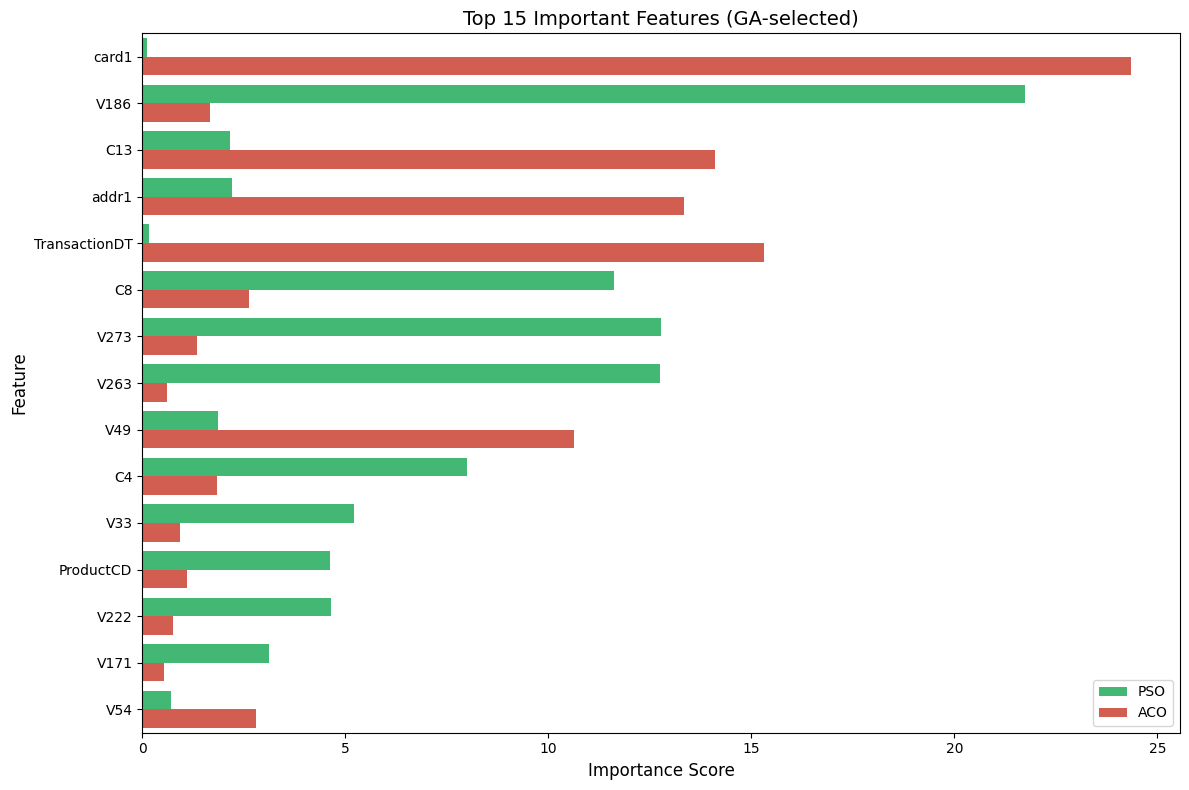


Top 10 Most Important GA-Selected Features:
      feature  pso_importance  aco_importance  avg_importance
        card1        0.126489       24.342434       12.234461
         V186       21.733241        1.682403       11.707822
          C13        2.151638       14.108944        8.130291
        addr1        2.219835       13.340503        7.780169
TransactionDT        0.160361       15.319888        7.740124
           C8       11.618578        2.638107        7.128342
         V273       12.775883        1.350997        7.063440
         V263       12.755645        0.621487        6.688566
          V49        1.866770       10.629125        6.247947
           C4        8.009132        1.839801        4.924467


In [12]:
import seaborn as sns
plt.figure(figsize=(12, 8))
feature_importance = pd.DataFrame({
    'feature': X_train_ga.columns,
    'pso_importance': final_model_pso.get_feature_importance(),
    'aco_importance': final_model_aco.get_feature_importance()
})

# Sort by average importance
feature_importance['avg_importance'] = (feature_importance['pso_importance'] + 
                                       feature_importance['aco_importance']) / 2
feature_importance = feature_importance.sort_values('avg_importance', ascending=False)

# Reshape for seaborn
plot_data = pd.melt(
    feature_importance, 
    id_vars=['feature'], 
    value_vars=['pso_importance', 'aco_importance'],
    var_name='model', 
    value_name='importance'
)
plot_data['model'] = plot_data['model'].map({'pso_importance': 'PSO', 'aco_importance': 'ACO'})

# Top 15 features
top_features = feature_importance.head(15)['feature'].tolist()
plot_data_top = plot_data[plot_data['feature'].isin(top_features)]

# Plot
sns.barplot(
    data=plot_data_top, 
    x='importance', 
    y='feature', 
    hue='model',
    palette=['#2ecc71', '#e74c3c']
)
plt.title('Top 15 Important Features (GA-selected)', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.legend(title='')
plt.tight_layout()
plt.show()

# Print the top features and their importance scores
print("\nTop 10 Most Important GA-Selected Features:")
print(feature_importance[['feature', 'pso_importance', 'aco_importance', 'avg_importance']].head(10).to_string(index=False))

### Compare PSO, ACO, and baseline results on GA-selected features

Now we'll do a comprehensive comparison of all three approaches: baseline CatBoost, PSO-optimized CatBoost, and ACO-optimized CatBoost, all using the same GA-selected features.

Evaluating models on GA-selected features:


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Performance Comparison on GA-Selected Features:
          accuracy  precision  recall      f1     auc  avg_precision
Baseline    0.8851     0.1976  0.7459  0.3124  0.9031         0.5265
PSO         0.9650     0.0000  0.0000  0.0000  0.7680         0.2660
ACO         0.9822     0.9039  0.5488  0.6829  0.9415         0.7456


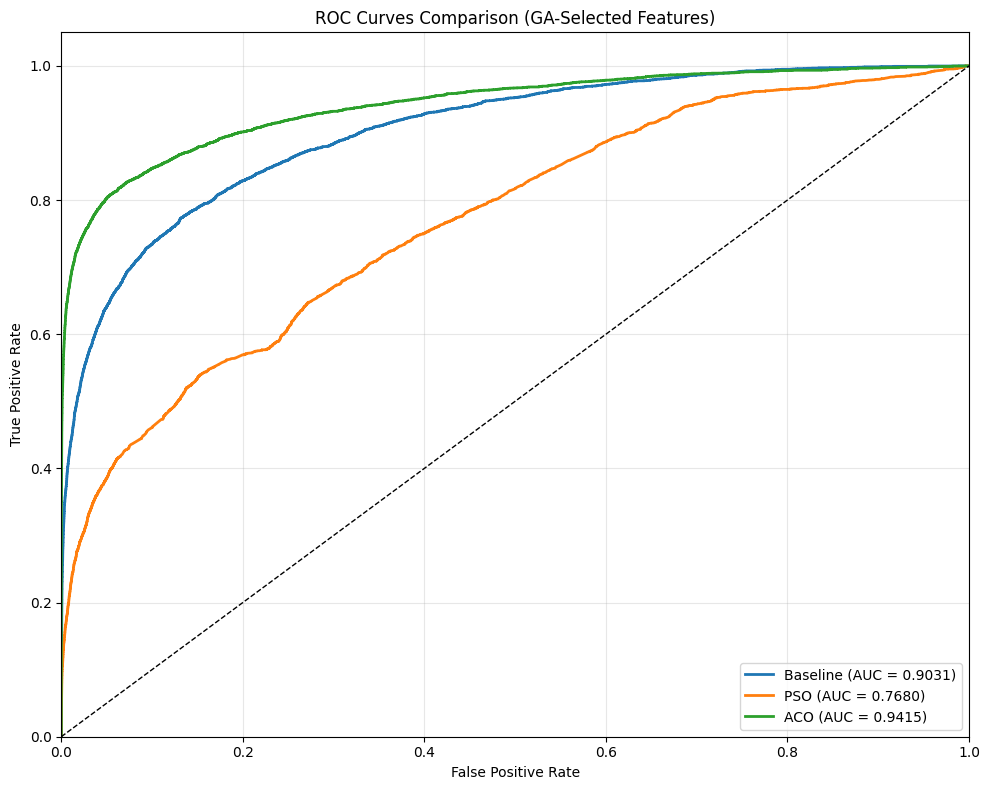

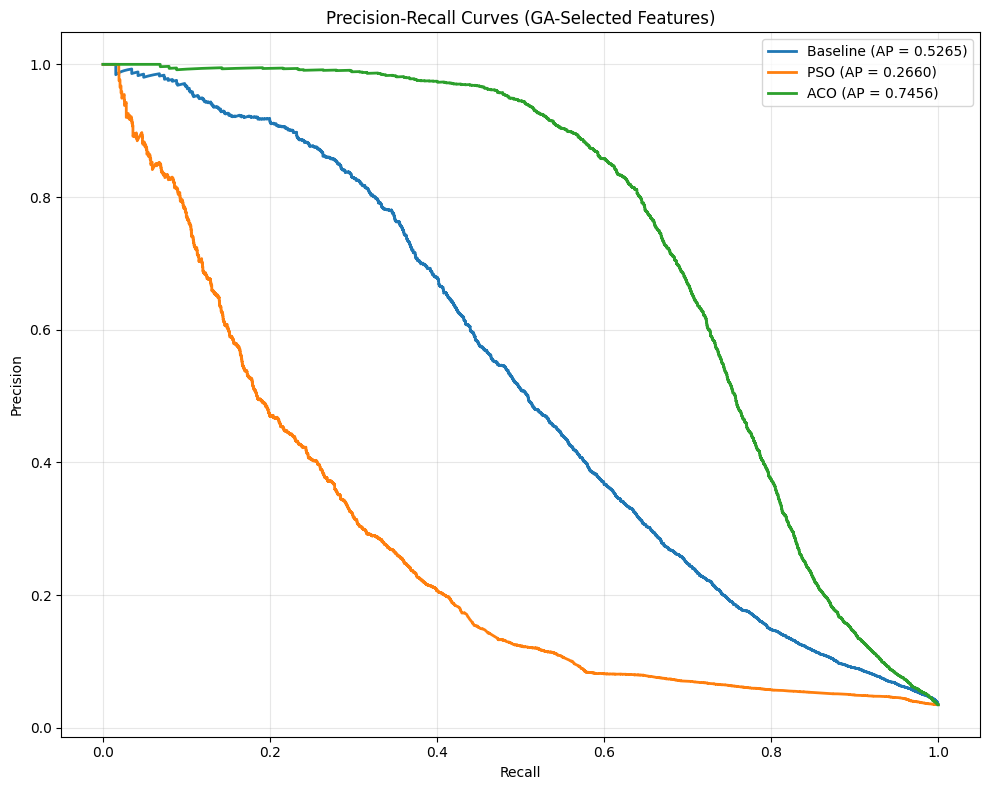


Improvement Summary on GA-Selected Features:

PSO vs Baseline:
  accuracy: 0.0799 absolute improvement (9.03% relative improvement)
  precision: -0.1976 absolute improvement (-100.00% relative improvement)
  recall: -0.7459 absolute improvement (-100.00% relative improvement)
  f1: -0.3124 absolute improvement (-100.00% relative improvement)
  auc: -0.1351 absolute improvement (-14.96% relative improvement)
  avg_precision: -0.2605 absolute improvement (-49.48% relative improvement)

ACO vs Baseline:
  accuracy: 0.0971 absolute improvement (10.97% relative improvement)
  precision: 0.7063 absolute improvement (357.46% relative improvement)
  recall: -0.1972 absolute improvement (-26.44% relative improvement)
  f1: 0.3705 absolute improvement (118.58% relative improvement)
  auc: 0.0384 absolute improvement (4.26% relative improvement)
  avg_precision: 0.2191 absolute improvement (41.61% relative improvement)


In [19]:
from sklearn import metrics
import seaborn as sns

# Evaluate all three models
print("Evaluating models on GA-selected features:")

# Get predictions for all models
y_pred_baseline = baseline_model_ga.predict(X_test_ga)
y_pred_pso = final_model_pso.predict(X_test_ga)
y_pred_aco = final_model_aco.predict(X_test_ga)

y_pred_proba_baseline = baseline_model_ga.predict_proba(X_test_ga)[:, 1]
y_pred_proba_pso = final_model_pso.predict_proba(X_test_ga)[:, 1]
y_pred_proba_aco = final_model_aco.predict_proba(X_test_ga)[:, 1]

# Calculate metrics for all models
models = {
    'Baseline': (y_pred_baseline, y_pred_proba_baseline),
    'PSO': (y_pred_pso, y_pred_proba_pso),
    'ACO': (y_pred_aco, y_pred_proba_aco)
}

results = {}
for name, (y_pred, y_pred_proba) in models.items():
    results[name] = {
        'accuracy': metrics.accuracy_score(y_test, y_pred),
        'precision': metrics.precision_score(y_test, y_pred),
        'recall': metrics.recall_score(y_test, y_pred),
        'f1': metrics.f1_score(y_test, y_pred),
        'auc': metrics.roc_auc_score(y_test, y_pred_proba),
        'avg_precision': metrics.average_precision_score(y_test, y_pred_proba)
    }

# Display results as a table
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)
print("\nPerformance Comparison on GA-Selected Features:")
print(comparison_df)

# ROC curves comparison
plt.figure(figsize=(10, 8))
for name, (_, y_pred_proba) in models.items():
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison (GA-Selected Features)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Precision-Recall curves
plt.figure(figsize=(10, 8))
for name, (_, y_pred_proba) in models.items():
    precision, recall, _ = metrics.precision_recall_curve(y_test, y_pred_proba)
    avg_precision = metrics.average_precision_score(y_test, y_pred_proba)
    plt.plot(recall, precision, lw=2, label=f'{name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves (GA-Selected Features)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary of improvements
print("\nImprovement Summary on GA-Selected Features:")
baseline_metrics = results['Baseline']
for name in ['PSO', 'ACO']:
    print(f"\n{name} vs Baseline:")
    for metric, value in results[name].items():
        improvement = value - baseline_metrics[metric]
        improvement_pct = (improvement / baseline_metrics[metric]) * 100
        print(f"  {metric}: {improvement:.4f} absolute improvement ({improvement_pct:.2f}% relative improvement)")

# Prepare GA-selected features for final model deployment

Let's save the final optimized model and export the list of GA-selected features for future use. This ensures we can reproduce the exact same preprocessing pipeline when deploying the model.

In [20]:
# Determine the best model based on AUC score
best_model_name = max(results, key=lambda x: results[x]['auc'])
print(f"The best model based on AUC is: {best_model_name}")

# Create a reference dictionary with GA feature indices and their names
ga_feature_mapping = {
    'indices': best_features,
    'names': selected_feature_names
}

# Export the GA feature information
import json
with open('ga_selected_features.json', 'w') as f:
    json.dump(ga_feature_mapping, f, indent=4)

# Save the best model
if best_model_name == 'PSO':
    best_model = final_model_pso
elif best_model_name == 'ACO':
    best_model = final_model_aco
else:
    best_model = baseline_model_ga

best_model.save_model('fraud_detection_best_model.cbm')

print(f"\nFinal model saved as 'fraud_detection_best_model.cbm'")
print(f"GA-selected features saved to 'ga_selected_features.json'")

# Function to preprocess and predict using the saved model
def predict_fraud(new_data, feature_mapping_path='ga_selected_features.json', model_path='fraud_detection_best_model.cbm'):
    """
    Predict fraud using the saved model and GA-selected features
    
    Args:
        new_data: DataFrame with the same columns as the original training data
        feature_mapping_path: Path to the saved GA feature mapping
        model_path: Path to the saved model
        
    Returns:
        Fraud predictions (1 for fraud, 0 for not fraud)
    """
    # Load feature mapping
    with open(feature_mapping_path, 'r') as f:
        feature_mapping = json.load(f)
    
    feature_names = feature_mapping['names']
    
    # Select only the GA-selected features
    if all(name in new_data.columns for name in feature_names):
        X_new = new_data[feature_names]
    else:
        indices = feature_mapping['indices']
        X_new = new_data.iloc[:, indices]
    
    # Load model and predict
    model = CatBoostClassifier()
    model.load_model(model_path)
    
    return model.predict(X_new)

print("\nCreated utility function 'predict_fraud()' for easy model deployment")

The best model based on AUC is: ACO

Final model saved as 'fraud_detection_best_model.cbm'
GA-selected features saved to 'ga_selected_features.json'

Created utility function 'predict_fraud()' for easy model deployment
